In [46]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy
import sklearn
import librosa
import librosa.display
import IPython.display as ipd
import json
from scipy.signal import find_peaks
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from random import shuffle

In [20]:
audio_path = 'data/amalfi/song.ogg'
y, sr = librosa.load(audio_path)

with open('data/amalfi/Easy.dat', 'r') as f:
    data = json.load(f)
    t = np.array(sorted(list(set([el['_time'] for el in data['_notes']]))))
    
tempo = 122    # from info.dat
dur = librosa.get_duration(y=y, sr=sr)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=1)

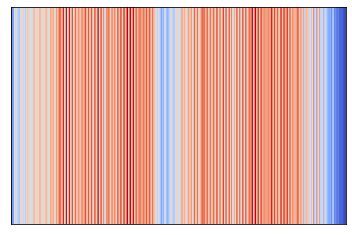

In [22]:
librosa.display.specshow(np.atleast_2d(mfcc))

In [23]:
mfcc.shape

(1, 9531)

In [24]:
mask = librosa.time_to_frames(t / tempo * 60, hop_length=512)
res = np.zeros(mfcc.shape[1])
res[mask] = 1
np.unique(res, return_counts=True)

(array([0., 1.]), array([8746,  785], dtype=int64))

In [25]:
np.corrcoef(mfcc[0], res)

array([[1.        , 0.22778929],
       [0.22778929, 1.        ]])

In [26]:
res

array([0., 0., 0., ..., 0., 0., 0.])

In [35]:
clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf.fit(mfcc.T, res)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [36]:
clf.score(mfcc.T, res)

0.9335851432168712

In [37]:
clf.get_depth()

10

In [40]:
def get_xy(audio_path, level_path, tempo):
    # read audio and calculate tempo
    y, sr = librosa.load(audio_path)

    # get mfcc
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=1)
    X = mfcc.T

    # read level
    with open(level_path, 'r') as f:
        data = json.load(f)
        t = np.array(sorted(list(set([el['_time'] for el in data['_notes']]))))
        
        mask = librosa.time_to_frames(t / tempo * 60, hop_length=512)
        res = np.zeros(mfcc.shape[1])
        res[mask] = 1
        
    return X, res

In [41]:
get_xy('data/amalfi/song.ogg', 'data/amalfi/Easy.dat', 122)

(array([[-455.07547],
        [-455.07547],
        [-455.07547],
        ...,
        [-455.07547],
        [-455.07547],
        [-455.07547]], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [44]:
df = pd.read_csv('data_info2.csv')
df.head()

,song_id,song_name,song_author,song_file,bpm,Easy,Normal,Hard,Expert,ExpertPlus
0,aaj,Aaj,Bloodywood,song.ogg,180.000000,Easy.dat,NaN,NaN,NaN,NaN
1,africatotometalcover,Africa - Toto (Metal Cover),"Leo Moracchioli, Rabea, Hannah",song.ogg,105.000000,NaN,NaN,NaN,NaN,ExpertPlus.dat
2,afterlife,Afterlife,Avenged Sevenfold,song.ogg,220.000000,Easy.dat,NaN,NaN,NaN,NaN
3,alerion,Alerion,Asking Alexandria,song.ogg,130.000000,NaN,NormalStandard.dat,HardStandard.dat,NaN,ExpertPlusStandard.dat
4,alittlepieceofheaven,A Little Piece of Heaven,Avenged Sevenfold,song.ogg,144.985992,NaN,NaN,NaN,NaN,NaN


In [47]:
song_ids = list(df[~df['Easy'].isnull()]['song_id'])
shuffle(song_ids)

song_ids_train = song_ids[:400]
song_ids_test = song_ids[400:]

len(song_ids_train), len(song_ids_test)

(400, 172)

In [50]:
df_train = df[df['song_id'].isin(song_ids_train)]
df_test = df[df['song_id'].isin(song_ids_test)]
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [51]:
train_X, test_X = [], []
train_y, test_y = [], []

In [52]:
for i, el in df_train.iterrows():
    try:
        path = 'data/' + el['song_id'] + '/'
        el_X, el_y = get_xy(path + el['song_file'], path + el['Easy'], el['bpm'])
        train_X.append(el_X)
        train_y.append(el_y)
    except:
        print('Error: ', i)
        
    if i % 10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80
90
Error:  100
100
110
120
130
140
150
160
170
180
190
200
210
Error:  215
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390


In [53]:
X_train = np.vstack(train_X)
X_train.shape

(3776241, 1)

In [54]:
y_train = np.hstack(train_y)
y_train.shape

(3776241,)

In [55]:
np.save('X_train_mfcc.npy', X_train)
np.save('y_train_mfcc.npy', y_train)

In [56]:
for i, el in df_test.iterrows():
    try:
        path = 'data/' + el['song_id'] + '/'
        el_X, el_y = get_xy(path + el['song_file'], path + el['Easy'], el['bpm'])
        test_X.append(el_X)
        test_y.append(el_y)
    except:
        print('Error: ', i)
        
    if i % 10 == 0:
        print(i)

0
10
20
30
40
50
60
Error:  67
70
80
90
100
110
120
130
140
150
160
170


In [57]:
y_test, y_val = test_y[:85], test_y[85:]
X_test, X_val = test_X[:85], test_X[85:]

X_test = np.vstack(X_test)
X_val = np.vstack(X_val)

y_test = np.hstack(y_test)
y_val = np.hstack(y_val)

np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)